In [ ]:
#!pip install opencv-python
#!pip install scikit-learn
#!pip install imblearn
import cv2
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

# 1. READ-IN DATA TO DF

In [3]:
df = pd.read_csv("labels-map-proj_v3_2.txt", sep=" ", header=None, names=["image", "label"])

# filter all images that end with fv, brt, r90, r180, r270, and fh
df = df[~df["image"].str.contains("fv|brt|r90|r180|r270|fh")]
print(df.shape)
df.head(5)

(10815, 2)


,image,label
0,ESP_013049_0950_RED-0067.jpg,7
7,ESP_019697_2020_RED-0024.jpg,1
14,ESP_015962_1695_RED-0016.jpg,1
21,ESP_013049_0950_RED-0118.jpg,7
28,ESP_015962_1695_RED-0017.jpg,1


In [4]:
df["label"].value_counts()

label
0    8802
1     794
6     298
3     267
4     250
2     166
7     164
5      74
Name: count, dtype: int64

# 2. DELETE 8k RANDOM IMAGES & SHUFFLE

In [6]:
# delte 7802 random images from the category with label 0
df_us = df.drop(df[df["label"] == 0].sample(7702, random_state=1).index)
df_us["label"].value_counts()

label
0    1100
1     794
6     298
3     267
4     250
2     166
7     164
5      74
Name: count, dtype: int64

In [7]:
# shuffle the dataframe
df_us = df_us.sample(frac=1, random_state=1).reset_index(drop=True)
df_us.head(5)

,image,label
0,ESP_018720_2655_RED-0035.jpg,2
1,ESP_046991_0950_RED-0024.jpg,7
2,ESP_039350_1915_RED-0186.jpg,1
3,ESP_014156_1865_RED-0023.jpg,3
4,ESP_013049_0950_RED-0088.jpg,7


# 3. READ-IN TO PIXELS

In [9]:
def load_images_labels_from_df(df, folder):
    images = []
    labels = []
    for i in range(len(df)):
        img = cv2.imread(folder+"/"+df.iloc[i][0], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            labels.append(df.iloc[i][1])
    return np.array(images), np.array(labels)

In [10]:
X, y = load_images_labels_from_df(df_us, "map-proj-v3_2")
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)
print(X.shape[0])

[0 1 2 3 4 5 6 7] [1100  794  166  267  250   74  298  164]
3113


# 4. NORMALIZE DATA TO 0-1

In [12]:
X_norm = X / 255.0
print(X_norm.min())
print(X_norm.max())

0.0
1.0


# 5. TRAIN-TEST SPLIT

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(X_norm, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, "Train")
print(X_test.shape, y_test.shape, "Test")
print(X_val.shape, y_val.shape, "Validation")

(1867, 227, 227) (1867,) Train
(872, 227, 227) (872,) Test
(374, 227, 227) (374,) Validation


In [15]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train, return_counts=True)[1]/y_train.shape[0])

print(np.unique(y_test, return_counts=True))
print(np.unique(y_test, return_counts=True)[1]/y_test.shape[0])

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([690, 452,  92, 168, 153,  41, 180,  91]))
[0.36957686 0.24209963 0.04927691 0.08998393 0.08194965 0.02196036
 0.09641136 0.0487413 ]
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([299, 238,  51,  66,  66,  24,  77,  51]))
[0.34288991 0.27293578 0.05848624 0.07568807 0.07568807 0.02752294
 0.08830275 0.05848624]


# 6. IMBALANCE HANDLING

## 6.0 Flatten Images

In [18]:
X_reshaped = X_train.flatten().reshape(X_train.shape[0], 51529)
print(X_train.shape)
print(X_reshaped.shape)

(1867, 227, 227)
(1867, 51529)


## 6.1 ADASYN

In [20]:
adasyn = ADASYN(sampling_strategy="not majority", random_state=1)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_reshaped, y_train) # type: ignore

## 6.2 OVERSAMPLING

In [22]:
oversampler = RandomOverSampler(sampling_strategy="not majority", random_state=3)
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y_train) # type: ignore

In [23]:
l1 = pd.DataFrame(X_resampled[np.where(y_resampled == 1)[0]])
print(f"Number of duplicates for the first label after oversampling: {l1.duplicated().sum()}")
all_l = pd.DataFrame(X_resampled)
print(f"Number of duplicates for all labels after oversampling: {all_l.duplicated().sum()}")

Number of duplicates for the first label after oversampling: 238
Number of duplicates for all labels after oversampling: 3653


In [24]:
unique, counts = np.unique(y_train, return_counts=True)
unique_a, counts_a = np.unique(y_train_adasyn, return_counts=True)
unique_b, counts_b = np.unique(y_resampled, return_counts=True)
print(X_train_adasyn.shape)
print(unique, counts)
print(unique_a, counts_a)
print(unique_b, counts_b)

(5482, 51529)
[0 1 2 3 4 5 6 7] [690 452  92 168 153  41 180  91]
[0 1 2 3 4 5 6 7] [690 651 690 685 668 681 723 694]
[0 1 2 3 4 5 6 7] [690 690 690 690 690 690 690 690]


In [25]:
X_t_A = X_train_adasyn.reshape(X_train_adasyn.shape[0], 227, 227) # type: ignore
y_t_A = y_train_adasyn

X_t_O = X_resampled.reshape(X_resampled.shape[0], 227, 227) # type: ignore
y_t_O = y_resampled

print(f"Shape of training instances generated by ADASYN: \n{X_t_A.shape}, correspoding y: {y_t_A.shape}")
print(f"Shape of training instances generated by RandomOverSampler: \n{X_t_O.shape}, correspoding y: {y_t_O.shape}")

Shape of training instances generated by ADASYN: 
(5482, 227, 227), correspoding y: (5482,)
Shape of training instances generated by RandomOverSampler: 
(5520, 227, 227), correspoding y: (5520,)


# 7. AUGMENTATION
1. Rotate 90
2. Rotate 180
3. Rotate 270
4. Flip Horizontally
5. Flip Vertically
6. Zoom

In [29]:
def zoom_at(img, zoom=1.0):
    h, w, = [zoom * i for i in img.shape]
    cx, cy = w/2, h/2
    img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
    img = img[int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
              int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5))]
    return img

def augment_images(images, labels):
    """
    Augments a numpy array of images by rotating them by 90, 180, and 270 degrees, flipping them horizontally and
    vertically, and zooming in on them.
    
    Args:
    - images (numpy.ndarray): A numpy array of shape (N, H, W, C), where N is the number of images, H and W are the
                              height and width of the images, and C is the number of color channels.
                              
    Returns:
    - augmented_images (numpy.ndarray): A numpy array of shape (7N, H, W, C), where the first N images are the
                                         original images and the remaining 6N images are the augmented images.
    """
    # Initialize an empty numpy array to store the augmented images
    augmented_images = np.empty((7*images.shape[0], images.shape[1], images.shape[2]))
    augmented_labels = np.empty((7*images.shape[0]))
    

    # Loop through each image in the array and perform the augmentations
    for i in range(images.shape[0]):
        image = images[i]
        label = labels[i]

        # Add the original image to the output array
        augmented_images[(i*7)] = image
        augmented_labels[(i*7)] = label
        
        # Rotate the image by 90 degrees
        rotated_90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        augmented_images[(i*7)+1] = rotated_90
        augmented_labels[(i*7)+1] = label
        
        # Rotate the image by 180 degrees
        rotated_180 = cv2.rotate(image, cv2.ROTATE_180)
        augmented_images[(i*7)+2] = rotated_180
        augmented_labels[(i*7)+2] = label
        
        # Rotate the image by 270 degrees
        rotated_270 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        augmented_images[(i*7)+3] = rotated_270
        augmented_labels[(i*7)+3] = label
        
        # Flip the image horizontally
        flipped_horizontal = cv2.flip(image, 1)
        augmented_images[(i*7)+4] = flipped_horizontal
        augmented_labels[(i*7)+4] = label
        
        # Flip the image vertically
        flipped_vertical = cv2.flip(image, 0)
        augmented_images[(i*7)+5] = flipped_vertical
        augmented_labels[(i*7)+5] = label
        
        # Zoom in on the image
        zoomed_in = zoom_at(image, 1.2)
        augmented_images[(i*7)+6] = zoomed_in
        augmented_labels[(i*7)+6] = label

        print(f"Image, {i} done")

    return augmented_images, augmented_labels

In [30]:
X_t_A_A, y_t_A_A = augment_images(X_t_A, y_t_A)
X_t_O_A, y_t_O_A = augment_images(X_t_O, y_t_O)
print(f"Shape of original training data for ADASYN: {X_t_A.shape} with corresponding y: {y_t_A.shape}")
print(f"Shape of augmented training data for ADASYN: {X_t_A_A.shape} with corresponding y: {y_t_A_A.shape}")
print(f"Shape of original training data for RandomOverSampler: {X_t_O.shape} with corresponding y: {y_t_O.shape}")
print(f"Shape of augmented training data for RandomOverSampler: {X_t_O_A.shape} with corresponding y: {y_t_O_A.shape}")

Image, 0 done
Image, 1 done
Image, 2 done
Image, 3 done
Image, 4 done
Image, 5 done
Image, 6 done
Image, 7 done
Image, 8 done
Image, 9 done
Image, 10 done
Image, 11 done
Image, 12 done
Image, 13 done
Image, 14 done
Image, 15 done
Image, 16 done
Image, 17 done
Image, 18 done
Image, 19 done
Image, 20 done
Image, 21 done
Image, 22 done
Image, 23 done
Image, 24 done
Image, 25 done
Image, 26 done
Image, 27 done
Image, 28 done
Image, 29 done
Image, 30 done
Image, 31 done
Image, 32 done
Image, 33 done
Image, 34 done
Image, 35 done
Image, 36 done
Image, 37 done
Image, 38 done
Image, 39 done
Image, 40 done
Image, 41 done
Image, 42 done
Image, 43 done
Image, 44 done
Image, 45 done
Image, 46 done
Image, 47 done
Image, 48 done
Image, 49 done
Image, 50 done
Image, 51 done
Image, 52 done
Image, 53 done
Image, 54 done
Image, 55 done
Image, 56 done
Image, 57 done
Image, 58 done
Image, 59 done
Image, 60 done
Image, 61 done
Image, 62 done
Image, 63 done
Image, 64 done
Image, 65 done
Image, 66 done
Image

In [31]:
aug_names = ["Original", "Rotate90", "Rotate180", "Rotate270", "Flip Horizontal", "Flip Vertical", "Zoom"]
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

# function that generates 10 random integers from numpy array that are divisible by 7
def generate_random_integers(X, n):
    random_integers = []
    while len(random_integers) < n:
        integer = np.random.randint(0, len(X))
        if integer % 7 == 0:
            random_integers.append(integer)
    return random_integers

# create function that takes 10 random images from the augmented training data and plots them
def plot_augmented_images(X, y, aug_names, class_names, num_images):
    indices = generate_random_integers(X, num_images)
    fig, axes = plt.subplots(len(indices), 7, figsize=(15, 15))
    c = 0
    for i in indices:
        for j in range(7):
            axes[c, j].imshow(X[i+j], cmap="gray")
            axes[c, j].set_xticks([])
            axes[c, j].set_yticks([])
            
            axes[c, j].set_xlabel(aug_names[j] + " " + str(int(i+j)))
            if j == 0:
                axes[c, j].set_ylabel(class_names[int(y[i+j])])
        c += 1
    plt.show()

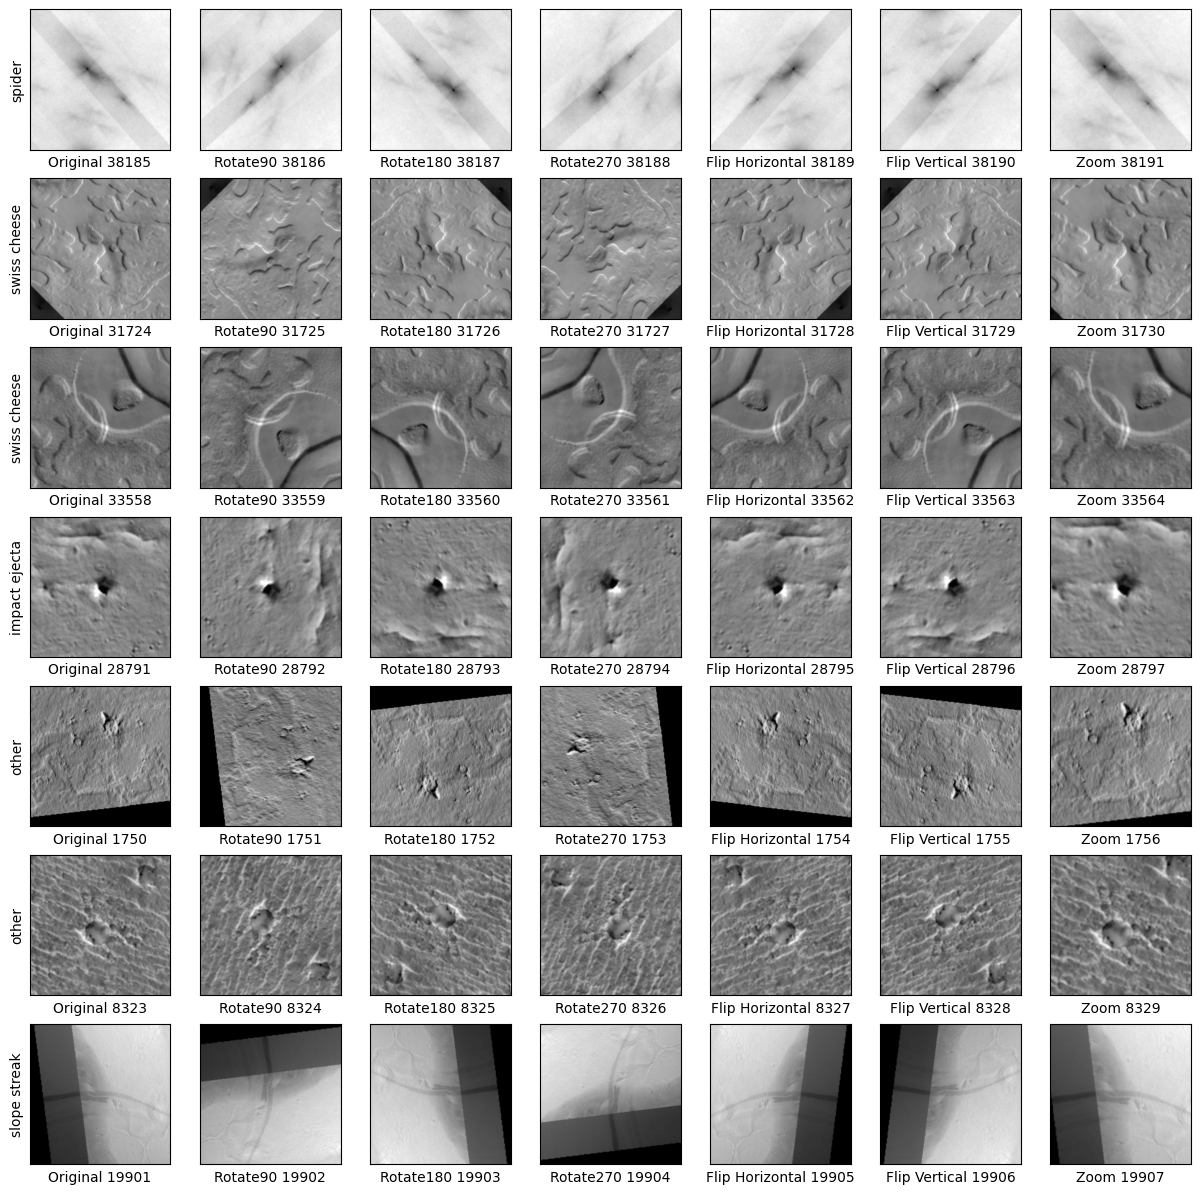

In [32]:
plot_augmented_images(X_t_A_A, y_t_A_A, aug_names, class_names, 7)

In [33]:
def shuffle_data(x, y):
    assert x.shape[0] == y.shape[0]
    p = np.random.permutation(x.shape[0])
    return x[p], y[p], p

X_t_A_A_S, y_t_A_A_S, p = shuffle_data(X_t_A_A, y_t_A_A)
X_t_O_A_S, y_t_O_A_S, p = shuffle_data(X_t_O_A, y_t_O_A)

# 8 Apply Models

In [ ]:
def model_evaluation(history, X_test, y_test, class_names):
    sns.lineplot(data=history.history['accuracy'], label='accuracy')
    sns.lineplot(data=history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
    print("Accuracy on the training set:", test_acc)
    y_pred_prob = model.predict(X_test)
    y_pred_class = y_pred_prob.argmax(axis=-1)

    print(classification_report(y_pred_class, y_test, target_names=class_names))
    fig = plt.figure(figsize=(10, 6))
    sns.heatmap(confusion_matrix(y_pred_class, y_test), xticklabels=class_names, yticklabels=class_names, annot=True)
    plt.show()

In [ ]:
!pip install tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import seaborn as sns

np.random.seed(1000)

# 8.1 AlexNet Oversampled Data

In [ ]:
alex_O = Sequential()

# 1st Convolutional Layer
alex_O.add(Conv2D(filters=96, input_shape=(227, 227, 1), kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu'))
# First Layer has 96 Filters, the input shape is 227x227x1, 
# the kernel size is 11x11, the stride is 4x4, and the padding is valid
# Relu is the activation function
# ==> Output: 55x55x96

# Max Pooling Layer
alex_O.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# The Pool Size is 3x3, the stride is 2x2, and the padding is valid
# ==> Output: 27x27x96

# 2nd Convolutional Layer
alex_O.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu'))
# Second Layer has 256 Filters, the kernel size is 5x5, 
# the stride is 1x1, and the padding is valid
# Relu is the activation function
# ==> Output: 23x23x256

# Max Pooling Layer
alex_O.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# The Pool Size is 3x3, the stride is 2x2, and the padding is valid
# ==> Output: 11x11x256

# 3rd Convolutional Layer
alex_O.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
# Third Layer has 384 Filters, the kernel size is 3x3,
# the stride is 1x1, and the padding is valid
# Relu is the activation function
# ==> Output: 9x9x384

# 4th Convolutional Layer
alex_O.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
# Fourth Layer has 384 Filters, the kernel size is 3x3,
# the stride is 1x1, and the padding is valid
# Relu is the activation function
# ==> Output: 7x7x384

# 5th Convolutional Layer
alex_O.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
# Fifth Layer has 256 Filters, the kernel size is 3x3,
# the stride is 1x1, and the padding is valid
# Relu is the activation function
# ==> Output: 5x5x256

# Max Pooling Layer
alex_O.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# The Pool Size is 3x3, the stride is 2x2, and the padding is valid
# ==> Output: 2x2x256

# Passing it to a Fully Connected layer
alex_O.add(Flatten())
# ==> Output: 1024

# 1st Fully Connected Layer
alex_O.add(Dense(4096, input_shape=(227*227*1,), activation='relu'))
# First Fully Connected Layer has 4096 neurons, the input shape is 227x227x1
# Relu is the activation function
# ==> Output: 4096

# Add Dropout to prevent overfitting
alex_O.add(Dropout(0.5))

# 2nd Fully Connected Layer
alex_O.add(Dense(4096, activation='relu'))
# Second Fully Connected Layer has 4096 neurons, the input shape is 4096
# Relu is the activation function
# ==> Output: 4096

# Add Dropout
alex_O.add(Dropout(0.5))

# Output Layer
alex_O.add(Dense(8))
alex_O.add(Activation('softmax'))

In [ ]:
alex_O.summary()

In [ ]:
# Hyperparameters
learning_rate = 0.01
weight_decay = 0.0005
momentum = 0.9
epochs = 90
batch_size = 128

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, decay=weight_decay, momentum=momentum, nesterov=True)

# Loss Function
loss_function = keras.losses.SparseCategoricalCrossentropy()

# Compile Model
alex_O.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Training
history_O = alex_O.fit(X_t_O_A_S, y_t_O_A_S, batch_size=32, epochs=10, validation_data=(X_val, y_val))

In [ ]:
model_evaluation(history, X_test, y_test, class_names)

# 8.2 AlexNet ADASYN DATA

In [ ]:
alex_A = Sequential()

# 1st Convolutional Layer
alex_A.add(Conv2D(filters=96, input_shape=(227, 227, 1), kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu'))
# First Layer has 96 Filters, the input shape is 227x227x1, 
# the kernel size is 11x11, the stride is 4x4, and the padding is valid
# Relu is the activation function
# ==> Output: 55x55x96

# Max Pooling Layer
alex_A.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# The Pool Size is 3x3, the stride is 2x2, and the padding is valid
# ==> Output: 27x27x96

# 2nd Convolutional Layer
alex_A.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu'))
# Second Layer has 256 Filters, the kernel size is 5x5, 
# the stride is 1x1, and the padding is valid
# Relu is the activation function
# ==> Output: 23x23x256

# Max Pooling Layer
alex_A.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# The Pool Size is 3x3, the stride is 2x2, and the padding is valid
# ==> Output: 11x11x256

# 3rd Convolutional Layer
alex_A.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
# Third Layer has 384 Filters, the kernel size is 3x3,
# the stride is 1x1, and the padding is valid
# Relu is the activation function
# ==> Output: 9x9x384

# 4th Convolutional Layer
alex_A.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
# Fourth Layer has 384 Filters, the kernel size is 3x3,
# the stride is 1x1, and the padding is valid
# Relu is the activation function
# ==> Output: 7x7x384

# 5th Convolutional Layer
alex_A.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
# Fifth Layer has 256 Filters, the kernel size is 3x3,
# the stride is 1x1, and the padding is valid
# Relu is the activation function
# ==> Output: 5x5x256

# Max Pooling Layer
alex_A.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# The Pool Size is 3x3, the stride is 2x2, and the padding is valid
# ==> Output: 2x2x256

# Passing it to a Fully Connected layer
alex_A.add(Flatten())
# ==> Output: 1024

# 1st Fully Connected Layer
alex_A.add(Dense(4096, input_shape=(227*227*1,), activation='relu'))
# First Fully Connected Layer has 4096 neurons, the input shape is 227x227x1
# Relu is the activation function
# ==> Output: 4096

# Add Dropout to prevent overfitting
alex_A.add(Dropout(0.4))

# 2nd Fully Connected Layer
alex_A.add(Dense(4096, activation='relu'))
# Second Fully Connected Layer has 4096 neurons, the input shape is 4096
# Relu is the activation function
# ==> Output: 4096

# Add Dropout
alex_A.add(Dropout(0.4))

# Output Layer
alex_A.add(Dense(8))
alex_A.add(Activation('softmax'))

In [ ]:
alex_A.summary()

In [ ]:
# Hyperparameters
learning_rate = 0.01
weight_decay = 0.0005
momentum = 0.9
epochs = 90
batch_size = 128

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, decay=weight_decay, momentum=momentum, nesterov=True)

# Loss Function
loss_function = keras.losses.SparseCategoricalCrossentropy()

# Compile Model
alex_A.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Training
history_A = alex_A.fit(X_t_A_A_S, y_t_A_A_S, batch_size=32, epochs=10, validation_data=(X_val, y_val))

In [ ]:
model_evaluation(history_A, X_test, y_test, class_names)

# 8.2 GoogleNet Oversampled Data

In [ ]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    path1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(path2)
    path3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(path3)
    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(path4)
    return concatenate([path1, path2, path3, path4], axis=-1)

def GoogLeNet():
    input_layer = Input(shape=(227, 227, 1))

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    x = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(1000, activation='sigmoid')(x)
    output_layer = Dense(8, activation='softmax')(x)

    # Define the model
    model_googlenet = Model(input_layer, output_layer)

    # Return the model
    return model_googlenet

In [ ]:
# Create the model
model = GoogLeNet()

In [ ]:
# Coompile the model
optimizer = Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy() 
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, decay=weight_decay, momentum=momentum, nesterov=True)

# Loss Function
loss_function = keras.losses.SparseCategoricalCrossentropy()

# Compile Model
alex_A.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Training
history_A = alex_A.fit(X_t_A_A_S, y_t_A_A_S, batch_size=32, epochs=10, validation_data=(X_val, y_val))